# Восстановление золота из руды

План работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Описание каждой стадии:**

***1. Флотация***

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

***2. Очистка***

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Описание данных**

***Технологический процесс***

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

***Параметры этапов***

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

***Наименование признаков***

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


Расчёт эффективности

Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 
Эффективность обогащения рассчитывается по формуле

$Recovery = C * (F - T) / F * (C - T) * 100\%$


Метрикой качества модели будет SMAPE - симметричное среднее абсолютное процентное отклонение.

![jupyter](https://wikimedia.org/api/rest_v1/media/math/render/svg/a894048083568c31cb423b23580f3ecfc9abe26e)

где $A_t$ – фактическое значение, $F_t$ – прогнозируемое значение, $n$ - количество объектов в выборке.

Нужно спрогнозировать две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:
$$
Итоговое SMAPE = 25\% * SMAPE(rougher) + 75\% * SMAPE(final)
$$

## Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (LinearRegression, 
                                  Lasso, LassoCV
                                 )
from sklearn.metrics import (r2_score, 
                             mean_absolute_error, 
                             make_scorer
                            )
from sklearn.dummy import DummyRegressor

In [2]:
test = pd.read_csv('gold_recovery_test_new.csv')
train = pd.read_csv('gold_recovery_train_new.csv')
full = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
data_list = [test, train, full]

test.name = 'Тестовая выборка'
train.name = 'Тренировочная выборка'
full.name = 'Полная выборка'

### Получение информации о датасетах

In [4]:
for data in data_list:
    print(f'\n{data.name}\n')
    display(data.info())


Тестовая выборка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float6

None


Тренировочная выборка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               

None


Полная выборка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 n

None

In [5]:
for data in data_list:
    for col in data.columns:
        try:
            full[col] = pd.to_numeric(full[col], downcast='float')
        except:
            print(data.name, col, 'нельзя перевести')

Тестовая выборка date нельзя перевести
Тренировочная выборка date нельзя перевести
Полная выборка date нельзя перевести


*Есть пропуски, количество столбцов в тестовой выборке меньше, чем в тренировочной и полной*

In [6]:
for data in data_list:
    display(data.name, 
            data.head(3))
    print('Количество дубликатов: ' 
          f'{data.duplicated().sum()}\n')

'Тестовая выборка'

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


Количество дубликатов: 0



'Тренировочная выборка'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Количество дубликатов: 0



'Полная выборка'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541214,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029368,9.968945,5.257782,42.701630,69.266197,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503265,11.950531,-501.331543,10.039246,-500.169983,7.984757,-500.582153,13.998353,-599.787170
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116447,10.507046,0.953716,16.208849,2.257889,...,14.015016,-502.520905,11.912783,-501.133392,10.070913,-500.129120,8.013877,-500.517578,14.028663,-601.427368


Количество дубликатов: 0



*Дубликаты отсутствуют, типы столбцов совпадают со значениями*

### Расчет Recovery

Посчитаем эффективность по формуле из условия

In [7]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

recovery_calculated = (C * (F - T) / (F * (C - T))) * 100

Сравним рассчитаную recovery с содержащейся в датасете

In [8]:
mean_absolute_error(train['rougher.output.recovery'],recovery_calculated)

9.649249696983847e-15

Значения MAE очень мало, похоже что данные в столбцах одинаковы. Для большей уверенности посчитаем R2

In [9]:
r2_score(train['rougher.output.recovery'],recovery_calculated)

1.0

*Коэффициент детерминации равен 1, значит данные идентичны*

## Предобработка данных

### Исследование отсутствующих столбцов

Посмотрим, какие столбцы отсутствуют в тестовой выборке

In [10]:
missing_columns = list(set(train.columns) ^ set(test.columns))

pd.Series(missing_columns).sort_values()

5                           final.output.concentrate_ag
16                          final.output.concentrate_au
3                           final.output.concentrate_pb
29                         final.output.concentrate_sol
12                                final.output.recovery
20                                 final.output.tail_ag
15                                 final.output.tail_au
4                                  final.output.tail_pb
21                                final.output.tail_sol
26                primary_cleaner.output.concentrate_ag
17                primary_cleaner.output.concentrate_au
8                 primary_cleaner.output.concentrate_pb
33               primary_cleaner.output.concentrate_sol
7                        primary_cleaner.output.tail_ag
27                       primary_cleaner.output.tail_au
18                       primary_cleaner.output.tail_pb
30                      primary_cleaner.output.tail_sol
28                      rougher.calculation.au_p

*Все отсутвующие столбцы - это онлайн-метрики, они появляются в процессе очистки и для обучения моделей они не подойдут. Мы сохранили их названия, они понадобятся нам в дальнейшем*

В тестовой выборке, помимо прочего, отсутствуют целевые признаки. Добавим их туда

In [11]:
# Сделаем merge по столбцу date, чтобы данные встали на свои места
test_fixed = test.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']],
                               on='date', how='left')

### Оценка пропусков

Узнаем количество пропусков во всех выборках

In [12]:
def nan_agg(data):
    return (data
             .isna()
             .agg(['sum','mean'])
             .T
             .sort_values(by='mean', 
                          ascending=False)
           )

for data in data_list:
    display(data.name,
            (nan_agg(data)
             .query('mean > 0')
            )
           )

'Тестовая выборка'

,sum,mean
rougher.input.floatbank11_xanthate,25.0,0.004726
rougher.input.feed_sol,21.0,0.003970
secondary_cleaner.state.floatbank3_a_air,9.0,0.001701
rougher.input.floatbank11_sulfate,8.0,0.001512
primary_cleaner.input.depressant,5.0,0.000945
rougher.input.floatbank10_sulfate,5.0,0.000945
primary_cleaner.input.xanthate,4.0,0.000756
primary_cleaner.input.sulfate,4.0,0.000756
rougher.input.feed_rate,3.0,0.000567
secondary_cleaner.state.floatbank2_a_air,3.0,0.000567


'Тренировочная выборка'

,sum,mean
secondary_cleaner.output.tail_sol,1605.0,0.113436
rougher.state.floatbank10_e_air,436.0,0.030815
rougher.input.floatbank11_xanthate,428.0,0.030249
primary_cleaner.output.concentrate_sol,286.0,0.020213
secondary_cleaner.state.floatbank2_a_air,217.0,0.015337
...,...,...
primary_cleaner.output.tail_ag,1.0,0.000071
final.output.concentrate_ag,1.0,0.000071
rougher.calculation.sulfate_to_au_concentrate,1.0,0.000071
rougher.output.tail_ag,1.0,0.000071


'Полная выборка'

,sum,mean
secondary_cleaner.output.tail_sol,1748.0,0.089922
rougher.input.floatbank11_xanthate,453.0,0.023304
rougher.state.floatbank10_e_air,436.0,0.022429
primary_cleaner.output.concentrate_sol,370.0,0.019034
secondary_cleaner.state.floatbank2_a_air,220.0,0.011317
...,...,...
primary_cleaner.state.floatbank8_b_level,1.0,0.000051
primary_cleaner.state.floatbank8_a_level,1.0,0.000051
primary_cleaner.state.floatbank8_d_level,1.0,0.000051
rougher.output.tail_ag,1.0,0.000051


*Если в тестовой выборке пропуски занимают доли процента, то в тренировочной и полной выборках их довольно много, чтобы сходу удалять. Разберемся с ними в дальнейшем*

## Анализ данных

### Изучение концентраций металлов на различных этапах

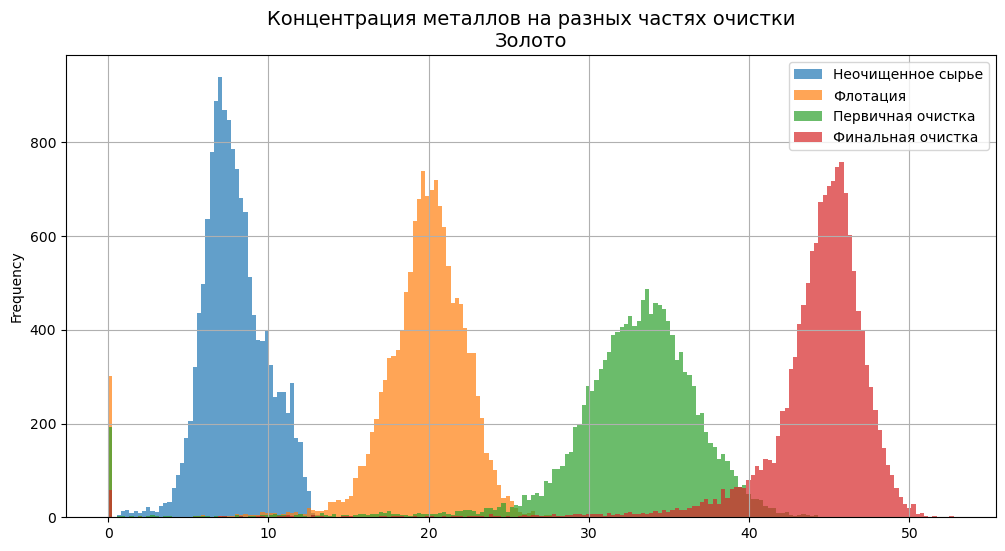

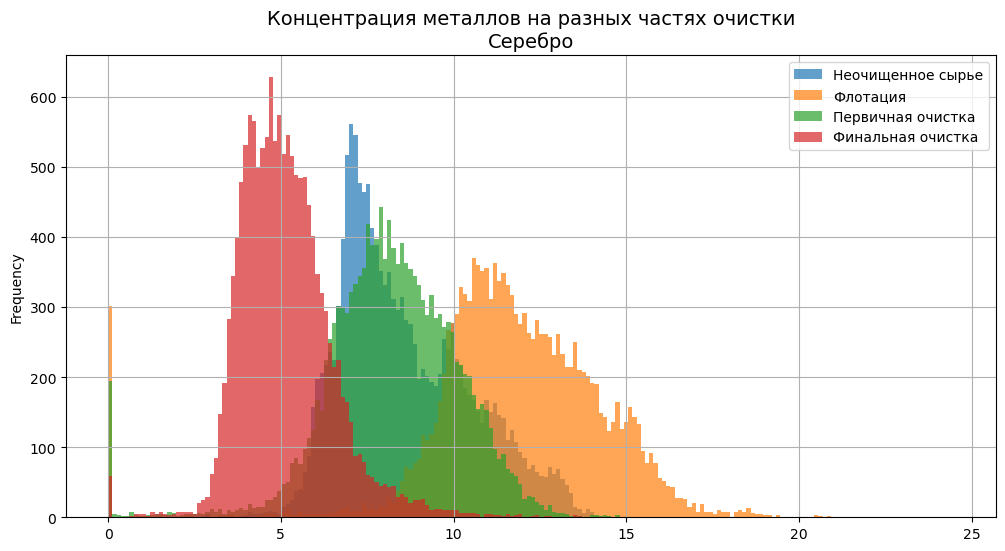

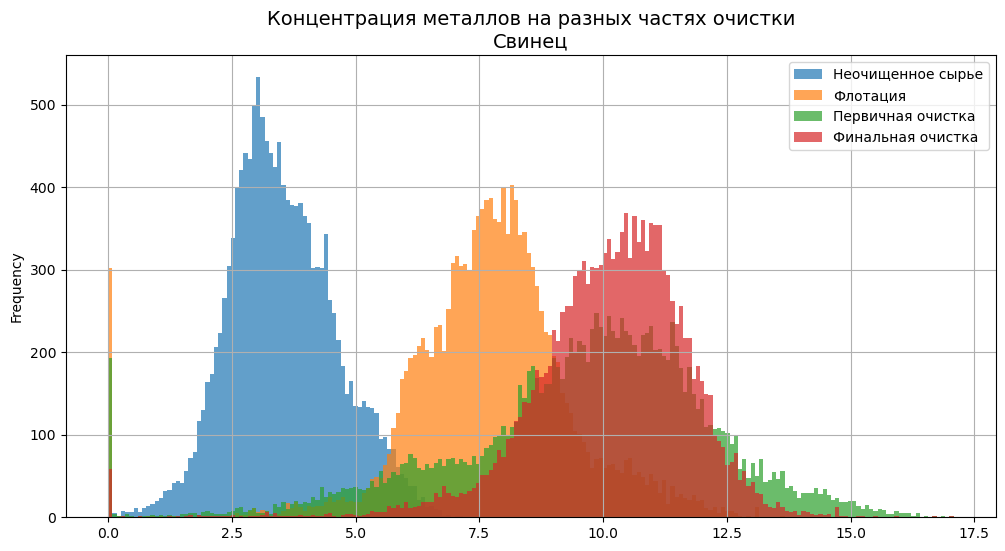

In [13]:
# Список всех столбцов с концентрацией веществ
conc_col = ['rougher.input.feed_', 
              'rougher.output.concentrate_',
              'primary_cleaner.output.concentrate_', 
              'final.output.concentrate_']

# Словарь с названиями металлов
types_list = {'au':'Золото','ag':'Серебро','pb':'Свинец'}

# Список с названиями этапов
stages = ['Неочищенное сырье','Флотация', 
          'Первичная очистка','Финальная очистка']

def hist(data):
    return data.plot(kind='hist', 
                      bins=200, 
                      grid=True, 
                      figsize=(12,6),
                      alpha=0.7
                     )

for types in types_list:
    hist(train[[x+types for x in conc_col]]
    )
    plt.title('Концентрация металлов на разных частях очистки\n'+
              f'{types_list.get(types)}', fontsize=14)
    plt.legend(stages);

*Концентрация золота увеличивается с каждым этапом, как и должна, серебро, напротив, показывает прирост концентрации после флотации, однако после следующих этапов очистки его концентрация последовательно снижается. Концентрация свинца увеличивается до стадии финальной очистки, после нее лишь уменьшается разброс значений, прироста содержания не наблюдается.  В целом, все распределения похожи на нормальные. Немного смущают столбы в районе нуля*

Взглянем на боксплот целевого вещества - золота

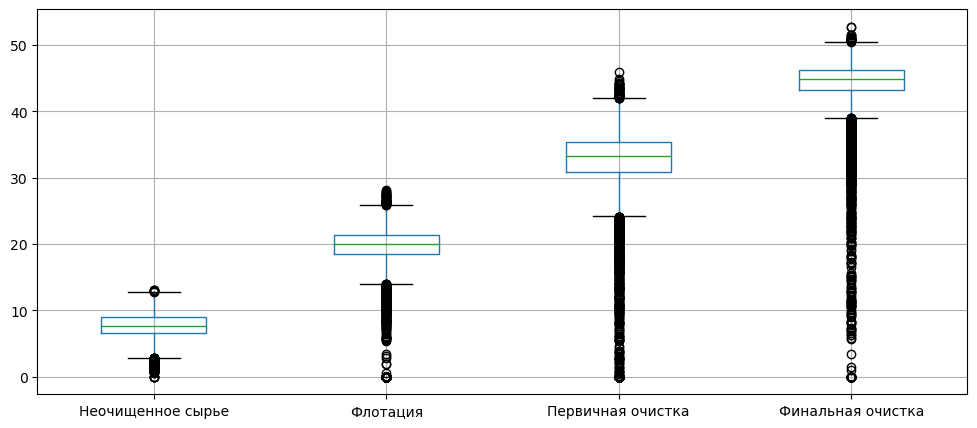

In [14]:
(train[[x+'au' for x in conc_col]]
        .boxplot(grid=True, 
                 figsize=(12,5), 
                 rot=0)
)
plt.xticks(ticks=[1,2,3,4],
           labels=stages);

Хвосты довольно жирные, но это объяснимо. А вот причина нулей не до конца ясна. Посмотрим на цифры

In [15]:
def nulls(data, types):
    return (data[[x+types for x in conc_col]] == 0).sum()

def nulls_df(data):
    return pd.DataFrame([nulls(data, x).values for x in types_list],
                        index = types_list,
                        columns=stages
                        ).T
nulls_df(train)

,au,ag,pb
Неочищенное сырье,0,0,0
Флотация,297,297,297
Первичная очистка,74,74,74
Финальная очистка,58,58,58


*Выглядит странно. Должно быть как минимум наоборот. Концентрация вещества не может быть нулевой после флотации, но потом вдруг появиться после первичной очистки. Или финальной. Похоже на аномалии, возможно сбой оборудования или что-то подобное. А судя по одинаковому их количеству у всего сырья, еще и в одних и тех же строках*

Посчитаем количество таких аномалий

In [16]:
anomaly_df = pd.DataFrame()
for types in types_list:
    anomaly = (train[((train[conc_col[1]+types] == 0) & 
                       (train[conc_col[3]+types] != 0)) |

                      ((train[conc_col[2]+types] == 0) &
                       (train[conc_col[3]+types] != 0)) |

                      ((train[conc_col[1]+types] == 0) & 
                       (train[conc_col[2]+types] != 0))]
              )
    anomaly_df[types] = anomaly.shape
anomaly_df = anomaly_df.T
anomaly_df[1] = round((anomaly_df[0]/train.shape[0]) * 100,2)
anomaly_df.columns=['Количество аномалий', 
                 'Процент к общему количеству']
anomaly_df    

,Количество аномалий,Процент к общему количеству
au,366,2.59
ag,366,2.59
pb,366,2.59


*Количество аномалий не превышает 3%, можно смело их удалять*

In [17]:
train_fixed = train.drop(anomaly.index)

nulls_df(train_fixed)

,au,ag,pb
Неочищенное сырье,0,0,0
Флотация,1,1,1
Первичная очистка,2,2,2
Финальная очистка,58,58,58


*Избавились от аномалий у всех типов сырья. Они были в одних и тех же строках. Судя по всему, действительно сбой оборудования*

### Сравнение гранул сырья

Сравним средние и медианные значения гранул в выборках

In [18]:
size_col = 'rougher.input.feed_size'

def sizing(func):
    if func == 'mean':
        sizes = pd.DataFrame([train_fixed[size_col].mean(),
                              test[size_col].mean()], columns=[size_col]
                             ).T
    if func == 'median':
        sizes = pd.DataFrame([train_fixed[size_col].median(),
                              test[size_col].median()], columns=[size_col]
                             ).T
    sizes[3] = round(((sizes[0]-sizes[1])/sizes[1]) * 100,2)
    sizes.columns = [[func,func,func],[train.name, test.name,'Разница,%']] 
    return sizes

sizing('mean').join(sizing('median'))

mean                             \
                        Тренировочная выборка Тестовая выборка Разница,%   
rougher.input.feed_size             60.172071        55.951097      7.54   

                                       median                             
                        Тренировочная выборка Тестовая выборка Разница,%  
rougher.input.feed_size             55.459793        50.841029      9.08

*Разница между средними размерами гранул в выборках составляет 7,54%, медианными размерами 9,08%* 

Взглянем на распределение значений

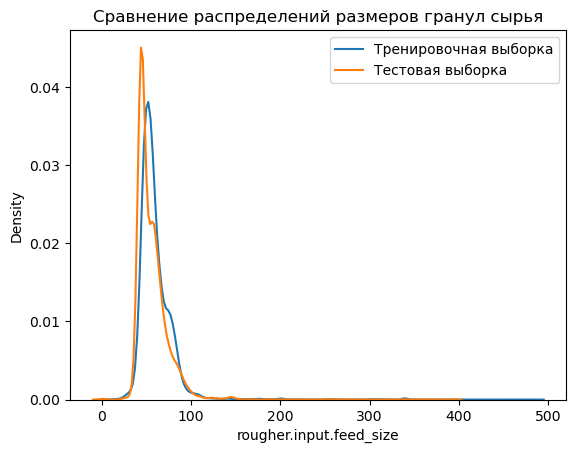

In [19]:
sns.kdeplot(train_fixed[size_col])
sns.kdeplot(test[size_col])
plt.title('Сравнение распределений размеров гранул сырья')
plt.legend([train.name,test.name]);

*Распределения значений на графике также выглядят похоже, критической разницы нет.*

### Исследование общей концентрации веществ

Построим для начала график распределения концентраций металлов

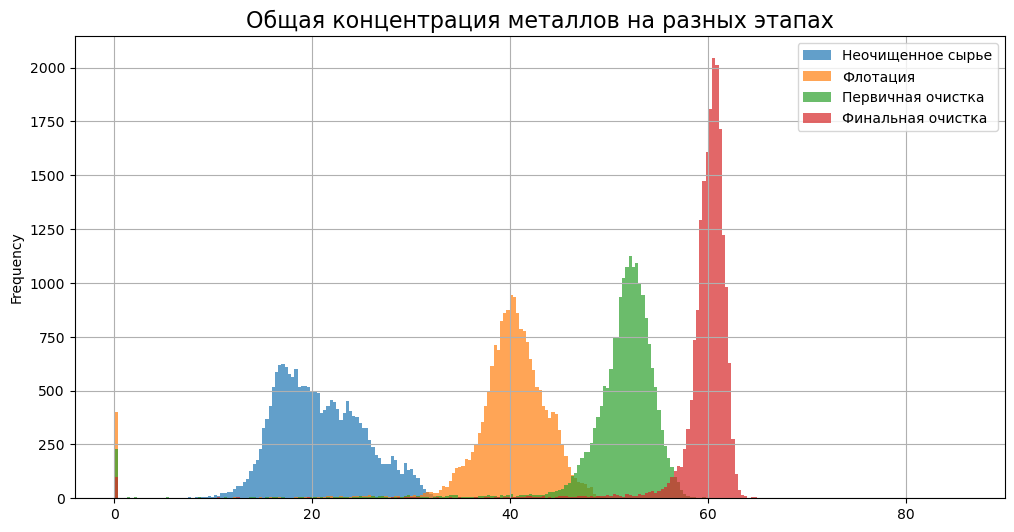

In [20]:
def conc():
    total_conc = pd.DataFrame(0 ,columns=conc_col, index=full.index)
    for col in conc_col:
        for types in types_list:
            total_conc[col] += full[col+types]
    total_conc.columns = stages
    hist(total_conc);
    return total_conc

total_conc = conc()
plt.title('Общая концентрация металлов на разных этапах',
         fontsize=16)
plt.xlim(-4,90);

Концентрация в целом увеличивается, как мы выяснили раньше. У нас есть еще одно вещество - соли. Посмотрим на график, содержащий все вещества

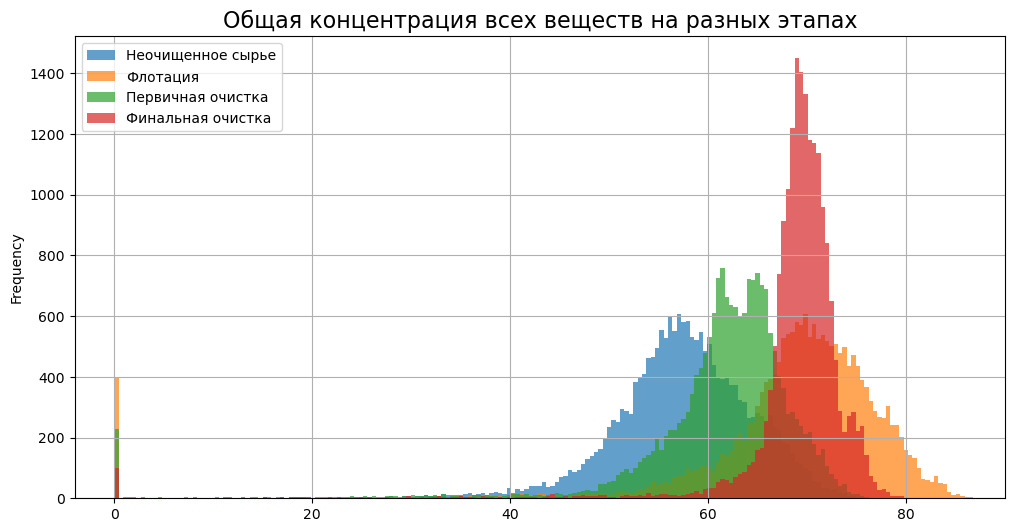

In [21]:
types_list['sol'] = 'Соли'
total_conc = conc()
plt.title('Общая концентрация всех веществ на разных этапах',
         fontsize=16)
plt.xlim(-4,90);

*Добавление соли в график больше уравновесило значения, поскольку ее концентрация, напротив, снижается от этапа к этапу. Также наблюдается аномалия, выраженная в полном отсутствии веществ в суммарных концентрациях на разных этапах, необходимо устранить ее*

In [22]:
full_conc = full.copy().join(total_conc)

for col in total_conc.columns:
    full_conc = full_conc[full_conc[col]>0]

train_fixed = train_fixed.set_index('date')
test_fixed = test_fixed.set_index('date')
full_conc = full_conc.set_index('date')

train_fixed = train_fixed.loc[train_fixed.index.isin(full_conc.index)]
test_fixed = test_fixed.loc[test_fixed.index.isin(full_conc.index)]

print('Выборки уменьшились на: \n', train.name,
      round((1-train_fixed.shape[0]/train.shape[0])*100,2),
      '%\n', test.name,
      round((1-test_fixed.shape[0]/test.shape[0])*100,2), '%')

Выборки уменьшились на: 
 Тренировочная выборка 7.16 %
 Тестовая выборка 4.73 %


### Исследование зависимостей в данных

Определим признаки, необходимые для построения моделей на текущий момент. Для этого мы вначале удалим онлайн-метрики и дату

In [23]:
train_corr = train_fixed.drop(missing_columns, axis=1, errors='ignore')

Теперь, среди оставшихся столбцов, выберем только столбцы, имеющие отношение к этапу флотации, т.е. содержащие в названии слово rougher

In [24]:
rougher_train_columns = []
for column in train_corr.columns:
    if 'rougher' in column: 
        rougher_train_columns.append(column)
        
print('Количество признаков:',
      '\nДля модели предсказывания эффективности обогащения чернового концентрата:', 
      len(rougher_train_columns),
      '\nДля модели предсказывания эффективности обогащения финального концентрата:',
      train_corr.shape[1])

Количество признаков: 
Для модели предсказывания эффективности обогащения чернового концентрата: 22 
Для модели предсказывания эффективности обогащения финального концентрата: 52


Построим последовательно диаграммы корреляций для тренировочной выборки

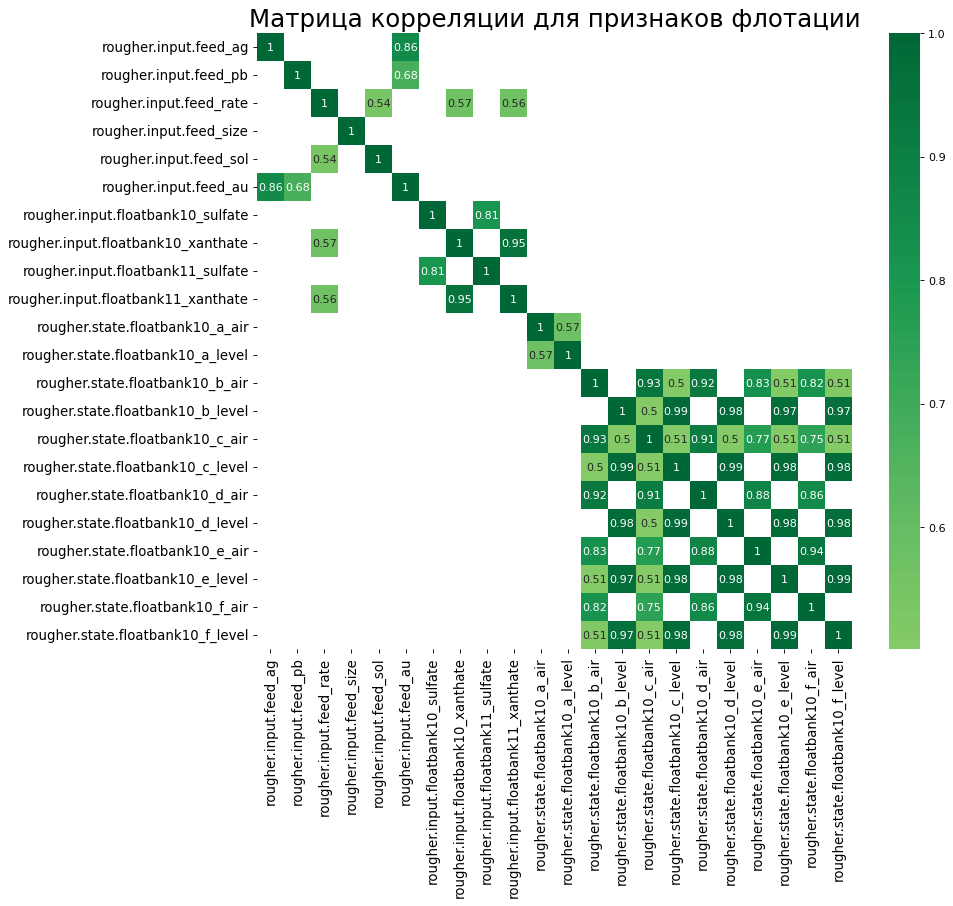

In [25]:
# Чтобы диаграммы были более информативны, поставим порог в 0.5
def corr_diagram(data, title):
    plt.figure(figsize=(12,10), dpi= 80)
    sns.heatmap(data.corr()[abs(data.corr()) >= .5], 
                xticklabels=data.corr().columns, 
                yticklabels=data.corr().columns, 
                cmap='RdYlGn', center=0, annot=True)

    plt.title(title, fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
corr_diagram(train_corr[rougher_train_columns], 
             'Матрица корреляции для признаков флотации')

In [26]:
test_corr = test_fixed.drop(rougher_train_columns, axis = 1)

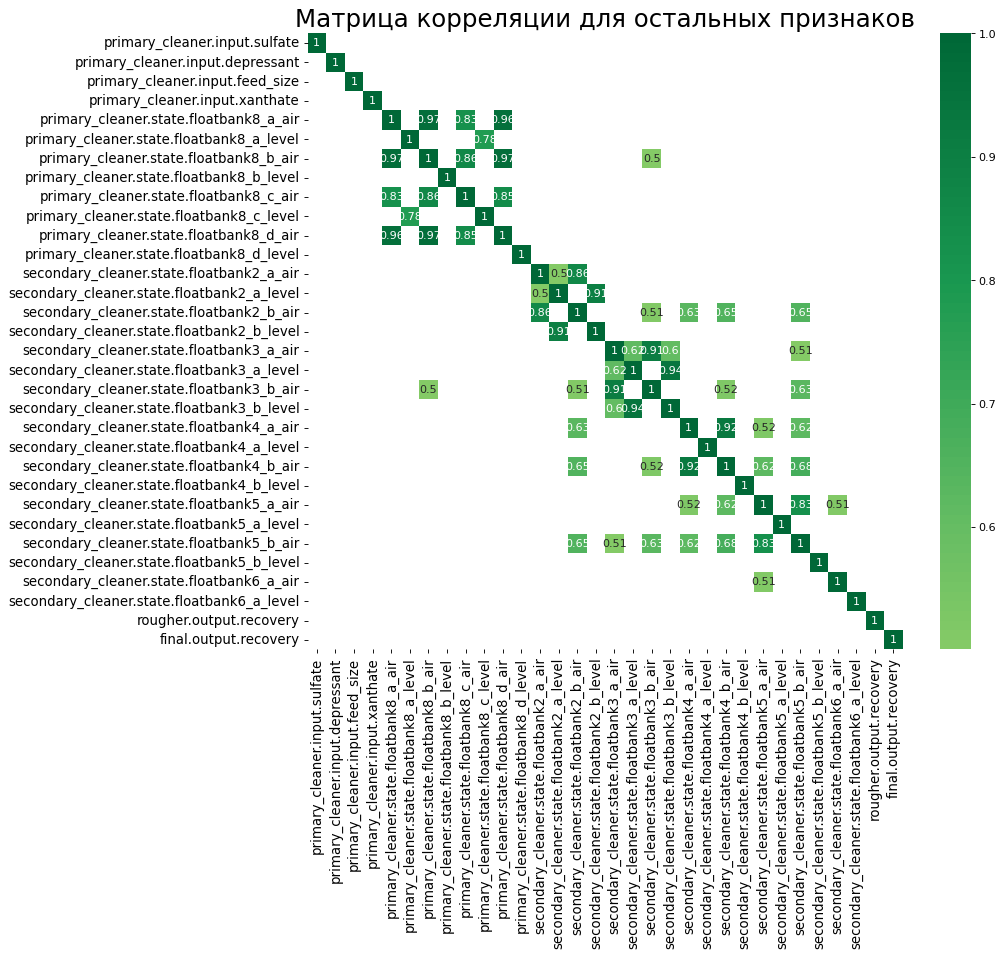

In [27]:
corr_diagram(test_corr, 
            'Матрица корреляции для остальных признаков')

*Видна явная мультиколлинеарность среди признаков, и их довольно много, чтобы просто отбросить. Будем учитывать эту проблему при построении модели*

### Расчет recovery и sMAPE

Теперь напишем функции для вычисления sMAPE и итоговой метрики final sMAPE. sMAPE это симметричный средний процент отклонения, поэтому наша задача будет состоять в минимизации значения этой метрики

In [28]:
def smape(target, predict):
    return (1/len(target) * np.sum(2 * np.abs(predict-target) / 
            (np.abs(target) + np.abs(predict))*100))

In [29]:
def smape_final(target_rougher, predict_rougher, 
                target_final, predict_final):
    return (smape(target_rougher,predict_rougher) * 0.25 +
            smape(target_final,predict_final) * 0.75)

Сделаем свой оценщик для кросс-валидации

In [30]:
my_scorer = make_scorer(smape, greater_is_better=False)

## Построение модели

### Выделение признаков

Для отделения целевого признака от остальных на обоих этапах для удобства напишем функцию

In [31]:
def featuring(data):
    data = data.drop('date', axis=1, errors='ignore')
    
    # Признаки для этапа обогащения чернового концентрата
    features_rougher = (data.drop(missing_columns, 
                                  axis=1, errors='ignore')
                        [rougher_train_columns]
                       )
    target_rougher = data['rougher.output.recovery']
    
    # Признаки для этапа обогащения финального концентрата
    features_final = data.drop(missing_columns, 
                               axis=1, errors='ignore')
    target_final = data['final.output.recovery']
    
    print('Размеры выборок: \nrougher: ',
      features_rougher.shape, target_rougher.shape, 
      '\nfinal: ',
      features_final.shape, target_final.shape)
    
    return (features_rougher, target_rougher,
            features_final, target_final)

### Обработка пропусков

Для выявления лучшей стратегии обработки пропусков воспользуемся линейной регрессией

In [32]:
def linear_model(features,target):   
    # Здесь же проведем масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Включаем кросс-валидацию, оценщиком будет наша функция sMAPE
    model = LinearRegression()
    cross_val = cross_val_score(model, features, target, 
                                cv=5, scoring=my_scorer).mean()
    
    # Функция вернет среднее значение sMAPE полученное после кросс-валидации 
    return cross_val

#### Метод drop

Для начала попробуем обработать пропуски просто удаляя их

In [33]:
train_dropna = train_fixed.dropna()
print('Количество пропусков: ',
      train_dropna.isna().sum().sum())

Количество пропусков:  0


In [34]:
(features_rougher, target_rougher, 
 features_final, target_final) = featuring(train_dropna)

Размеры выборок: 
rougher:  (10737, 22) (10737,) 
final:  (10737, 52) (10737,)


In [35]:
cross_val_rougher = (
    linear_model(features_rougher, target_rougher)
)
cross_val_final = (
    linear_model(features_final, target_final)
)

def smape_stats():
    return ([cross_val_rougher*-1, cross_val_final*-1])

stats = pd.DataFrame(smape_stats() ,columns=['drop'],
                    index=['cross_val_rougher', 'cross_val_final'])

In [36]:
display(stats)

,drop
cross_val_rougher,6.339313
cross_val_final,9.018601


#### Метод ffil

Так как наши значения структурированы по дате, можно попробовать способ заполнения пропусков предыдущим значением из датасета

In [37]:
train_ffiled = train_fixed.copy()
train_ffiled.ffill(axis='rows', inplace=True)
print('Количество пропусков: ',
      train_ffiled.isna().sum().sum())

Количество пропусков:  0


In [38]:
(features_rougher, target_rougher, 
 features_final, target_final) = featuring(train_ffiled)

Размеры выборок: 
rougher:  (13136, 22) (13136,) 
final:  (13136, 52) (13136,)


In [39]:
cross_val_rougher = (
    linear_model(features_rougher, target_rougher)
)
cross_val_final = (
    linear_model(features_final, target_final)
)

stats['ffil'] = smape_stats()
display(stats)

,drop,ffil
cross_val_rougher,6.339313,6.715724
cross_val_final,9.018601,10.164060


*Метод drop оказался лучше, в дальнейшем будем использовать его*

In [40]:
stats = stats.drop('ffil', axis=1, errors='ignore')
stats.columns = ['Линейная регрессия']
display(stats)

,Линейная регрессия
cross_val_rougher,6.339313
cross_val_final,9.018601


### Выбор модели

Выберем одну модель из 4 исследуемых: линейная регрессия, Lasso, дерево решений и случайный лес

In [41]:
# Удаляем пропуски
(features_rougher, target_rougher, 
 features_final, target_final) = featuring(train_dropna)

Размеры выборок: 
rougher:  (10737, 22) (10737,) 
final:  (10737, 52) (10737,)


#### Lasso

Так как в наших данных довольно много коррелирующих между собой признаков, помимо линейной регрессии мы используем модель, позволяющую отчасти решить проблему мультиколлинеарности - Lasso

In [42]:
def lasso_model(features,target):
    # Проводим масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Подключаем перебор параметров
    lasso_cv = LassoCV(alphas=np.linspace(0.1, 10, 200), 
                       cv=3, random_state=12345)
    lasso_cv.fit(features, target)
     
    # Обучаем модель
    alpha = lasso_cv.alpha_
    model = Lasso(alpha=alpha)
    model.fit(features, target)
    predict = model.predict(features)
    
    # Включаем кросс-валидацию, оценщиком будет наша функция sMAPE
    cross_val = cross_val_score(model, features, target, 
                                cv=5, scoring=my_scorer).mean()
    # Выведем на экран выбранные параметры
    print(alpha)
    # Функция вернет предсказанные значения а так же 
    # среднее значение sMAPE полученное после кросс-валидации
    # и значение alpha
    return predict, cross_val, alpha

In [43]:
print('rougher:')
predict_rougher, cross_val_rougher, alpha_rougher = (
    lasso_model(features_rougher, target_rougher)
)
print('final:')
predict_final, cross_val_final, alpha_final = (
    lasso_model(features_final, target_final)
)

rougher:
0.8462311557788945
final:
0.7467336683417085


In [44]:
stats['Lasso'] = smape_stats()
stats

,Линейная регрессия,Lasso
cross_val_rougher,6.339313,6.320283
cross_val_final,9.018601,8.072087


#### Дерево решений

In [45]:
def tree_model(features,target):
    # Проводим масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Подключаем GridSearchCV для определения параметров
    model = DecisionTreeRegressor()
    params = {'max_depth':range(1,10,1)}
    grid = GridSearchCV(model, params, cv=5, scoring=my_scorer)
    grid.fit(features, target)
    max_depth = grid.best_params_
    
    # Обучаем модель по определенным параметрам
    model = DecisionTreeRegressor(max_depth=max_depth['max_depth'],
                                  random_state=12345)
    model.fit(features, target)
    predict = model.predict(features)
    
    # Выведем на экран выбранные параметры
    print(max_depth)
    # Функция вернет предсказанные значения а так же 
    # среднее значение sMAPE полученное после GridSearchCV
    return predict, grid.best_score_

In [46]:
print('rougher:')
predict_rougher, cross_val_rougher = (
    tree_model(features_rougher, target_rougher)
)
print('final:')
predict_final, cross_val_final = (
    tree_model(features_final, target_final)
)

rougher:
{'max_depth': 2}
final:
{'max_depth': 1}


In [47]:
stats['Дерево решений'] = smape_stats()
display(stats)

,Линейная регрессия,Lasso,Дерево решений
cross_val_rougher,6.339313,6.320283,6.321272
cross_val_final,9.018601,8.072087,8.211124


#### Случайный лес

In [48]:
def forest_model(features,target):
    # Проводим масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Подключаем GridSearchCV для определения параметров
    model = RandomForestRegressor()
    params = {'max_depth':range(1,5,1),
             'n_estimators':range(10,31,10)}
    grid = GridSearchCV(model, params, cv=5, scoring=my_scorer)
    grid.fit(features, target)
    best_par = grid.best_params_
    
    # Обучаем модель по определенным параметрам
    model = RandomForestRegressor(max_depth=best_par['max_depth'],
                                  n_estimators=best_par['n_estimators'],
                                  random_state=12345)
    model.fit(features, target)
    predict = model.predict(features)
    
    # Выведем на экран выбранные параметры
    print(best_par)
    # Функция вернет предсказанные значения а так же 
    # среднее значение sMAPE полученное после GridSearchCV
    return predict, grid.best_score_

In [49]:
%%time
# Займет около двух с половиной минут
print('rougher:')
predict_rougher, cross_val_rougher = (
    forest_model(features_rougher, target_rougher)
)
print('final:')
predict_final, cross_val_final = (
    forest_model(features_final, target_final)
)

rougher:
{'max_depth': 4, 'n_estimators': 30}
final:
{'max_depth': 1, 'n_estimators': 30}
CPU times: user 1min 21s, sys: 2.96 ms, total: 1min 21s
Wall time: 1min 21s


In [50]:
stats['Случайный лес'] = smape_stats()
stats

,Линейная регрессия,Lasso,Дерево решений,Случайный лес
cross_val_rougher,6.339313,6.320283,6.321272,6.015042
cross_val_final,9.018601,8.072087,8.211124,8.147440


*Лучшее среднее значение sMAPE чернового концентрата показала модель случайный лес, финального концентрата - модель Lasso. Так как в итоговой метрике соотношение эффективности обогащения финального концентрата к черновому равно 3:1, сделаем выбор в пользу модели Lasso*

## Тестирование модели

In [51]:
# Удаляем пропуски в тестовой выборке
test_dropna = test_fixed.dropna()
print('Количество пропусков: ',
      test_dropna.isna().sum().sum())

Количество пропусков:  0


In [52]:
(features_rougher_test, target_rougher_test, 
 features_final_test, target_final_test) = featuring(test_dropna)

Размеры выборок: 
rougher:  (5013, 22) (5013,) 
final:  (5013, 52) (5013,)


### Тест Lasso

Проверим выбранную нами модель с рассчитанными параметрами на тестовых данных 

In [53]:
def lasso_model_test(features,target, features_test,target_test, alpha):
    # Здесь же проведем масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    features_test = scaler.transform(features_test)
    
    # Обучаем модель
    model = Lasso(alpha=alpha)
    model.fit(features, target)
    predict = model.predict(features_test)
    
    # Функция вернет предсказанные значения а так же значение sMAPE
    return predict, smape(target_test, predict)

In [54]:
predict_rougher, smape_rougher = (
    lasso_model_test(features_rougher, target_rougher,
                     features_rougher_test,target_rougher_test, alpha_rougher)
)
predict_final, smape_final_rec = (
    lasso_model_test(features_final, target_final,
                     features_final_test,target_final_test, alpha_final)
)

stats_test = pd.DataFrame([smape_rougher, smape_final_rec,
                           smape_final(target_rougher_test, predict_rougher, 
                                       target_final_test, predict_final)],
                          columns=['Lasso Тест'],
                          index=['sMAPЕ чернового концентрата',
                                  'sMAPE финального концентрата',
                                   'Итоговая sMAPE'])
display(stats_test)

,Lasso Тест
sMAPЕ чернового концентрата,4.078443
sMAPE финального концентрата,7.081491
Итоговая sMAPE,6.330729


### Тест на адекватность

Проверим нашу модель на адекватность с помощью Dummy

In [55]:
def dummy_model_test(features, target, 
                     features_test, target_test):
    # Здесь же проведем масштабирование признаков
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    features_test = scaler.transform(features_test)
    
    # Обучаем модель
    model = DummyRegressor(strategy="mean")
    model.fit(features, target)
    predict = model.predict(features_test)
    
    # Функция вернет предсказанные значения а так же значение sMAPE
    return predict, smape(target_test, predict)

In [56]:
predict_rougher, smape_rougher = (
    dummy_model_test(features_rougher, target_rougher,
                     features_rougher_test,target_rougher_test)
)
predict_final, smape_final_rec = (
    dummy_model_test(features_final, target_final,
                     features_final_test,target_final_test)
)

In [57]:
stats_test['Dummy'] = [smape_rougher, smape_final_rec,
                       smape_final(target_rougher_test, predict_rougher, 
                                   target_final_test, predict_final)]
display(stats_test)

,Lasso Тест,Dummy
sMAPЕ чернового концентрата,4.078443,5.306120
sMAPE финального концентрата,7.081491,8.124212
Итоговая sMAPE,6.330729,7.419689


## **Вывод**

В ходе исследования мы выявили высокую корреляцию признаков state между собой, что могло негативно отразиться на обучении моделей. Также выявили и удалили 2,59% аномалий в данных, когда нулевая концентрация веществ после обогащения чернового концентрата превращалась в ненулевые значения после обогащения финального концентрата. Далее удалили аномалии, связанные с нулевой суммарной концентрацией всех веществ на разных этапах. Выяснили, что в данном случае пропуски в данных полезнее удалять, чем обрабатывать. Выбранная в итоге модель - Lasso, прошла проверку на адекватность в сравнении с Dummy моделью.

Итоговые метрики sMAPE выглядят следующим образом: 

- Эффективность обогащения чернового концентрата: sMAPE = 4.07
- Эффективность обогащения финального концентрата: sMAPE = 7.08
- Итоговая метрика sMAPE final = 6.33

